In [179]:
import numpy as np
import pandas as pd
import pickle
import os

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
# evaluate multioutput regressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [305]:
# load data
def loadData(filename):
    data = pd.read_csv(filename)
    data['Time'] = pd.to_datetime(data.Time)
    return data

# data fusion takes previous 12h ours in 30min resolution
# prediction generates 8 days x 24 hours/day x 2 values/hour = 384 values
def generateFeatureVectorsAndTargets(data):
    X = []
    y = []
    for i in range(0, len(data) - 408):
        # extract hour of day from datetime64
        hour = data.iloc[5:6, 0].dt.hour.values[0]
        # extract day of the week from datetime64
        day = data.iloc[5:6, 0].dt.dayofweek.values[0]

        X.append(np.concatenate((np.array(data.iloc[i:i+24, 1]), [hour, day])))
        y.append(np.array(data.iloc[i+24:i+408, 1]))
    return np.array(X).tolist(), np.array(y).tolist()

# clear feature vectors with missing data
def clearFeatureVectors(X, y):
    X_clean = []
    y_clean = []
    for i in range(0, len(X)):
        # check if there is a nan value in the feature vector
        # check if there is a nan in the target vector
        # check if there are too many zeroes in the feature vector
        # check if there are too many zeros in the target vector
        if not np.isnan(X[i]).any() and not np.isnan(y[i]).any() and not np.count_nonzero(X[i] == 0) > 2 and not np.count_nonzero(X[i] == 0) > 10:
            X_clean.append(X[i])
            y_clean.append(y[i])
            
    return np.array(X_clean), np.array(y_clean)


def save_model(location):
    # create folder
    if not os.path.exists('../../models/alicante_{}_GDB'.format(location)):
        os.makedirs('../../models/alicante_{}_GDB'.format(location))

    # save model
    filename = '../../models/alicante_{}_GDB/model.pkl'.format(location)

    # save model
    pickle.dump(regressor, open(filename, 'wb'))


def test_saved_model(location):
    filename = '../../models/alicante_{}_GDB/model.pkl'.format(location)

    # load model
    loaded_model = pickle.load(open(filename, 'rb'))

    # evaluate model
    y_pred = loaded_model.predict(X_test)

    # calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return [ r2, mse, mae]

def load_data(location):
    # load data
    data = loadData('../../data/DataForModels/UnivariateClean/{}.csv'.format(location))
    # create feature vectors
    X, y = generateFeatureVectorsAndTargets(data)
    X, y = clearFeatureVectors(X, y)
    # weird bug
    X, y = clearFeatureVectors(X, y)

    # create train and test set
    X_train = X[:int(len(X)*0.8)]
    X_test = X[int(len(X)*0.8):]
    y_train = y[:int(len(y)*0.8)]
    y_test = y[int(len(y)*0.8):]

    return X_train, X_test, y_train, y_test

In [336]:
# start for location
location = "rambla"

# load data
X_train, X_test, y_train, y_test = load_data(location)

X_train = X
y_train = y

# data fusion takes previous 12h ours in 30min resolution
# prediction generates 8 days x 24 hours/day x 2 values/hour = 384 values
regressor = MultiOutputRegressor(GradientBoostingRegressor(random_state=0), n_jobs=6)

# train model
regressor.fit(X_train, y_train)

# evaluate model
y_pred = regressor.predict(X_test)

# calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

[r2, mse, mae]

[0.7969452660483775, 869690.1729870277, 733.5226911012629]

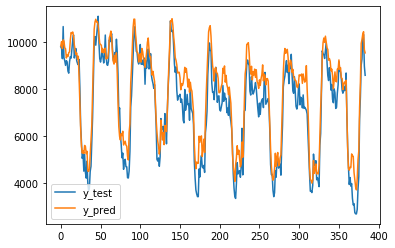

In [337]:
# plot results
import matplotlib.pyplot as plt

# %% 
# plot results
plt.plot(y_test[500], label='y_test')
plt.plot(y_pred[500], label='y_pred')
plt.legend()
plt.show()


In [338]:
save_model(location)

In [339]:
test_saved_model(location)

[0.7969452660483775, 869690.1729870277, 733.5226911012629]